In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import stats
import seaborn as sns; sns.set()
import os
from os.path import join, getsize
import nltk
from nltk import word_tokenize, sent_tokenize, tokenize
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

out_p = pd.read_csv('../data/Medicare_Charge_Outpatient_APC28_CY2015_Provider.csv')
in_p= pd.read_csv('../data/Medicare_Provider_Charge_Inpatient_DRGALL_FY2015.csv')

## _2015 In and Out Patient EDA_

### _Project Template_
> ####  1.  EDA for Medicare in and out patient utilization provider data from 2015.
> ####  2.  Investigate and accquire commercial data from 2015 for comparison. 
> ####  3.  Build interface for market comparison by DRG.

In [21]:
print(out_p.info())
print(in_p.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32532 entries, 0 to 32531
Data columns (total 11 columns):
APC                          32532 non-null object
Provider_ID                  32532 non-null int64
Provider_Name                32532 non-null object
Provider_Street_Address      32532 non-null object
Provider_City                32532 non-null object
Provider_State               32532 non-null object
Provider_Zip_Code            32532 non-null int64
Hospital_Referral_Region     32532 non-null object
Outpatient_Services          32532 non-null int64
Average_Submitted_Charges    32532 non-null float64
Average_Total_Payments       32532 non-null float64
dtypes: float64(2), int64(3), object(6)
memory usage: 2.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201876 entries, 0 to 201875
Data columns (total 12 columns):
DRG Definition                                201876 non-null object
Provider Id                                   201876 non-null int64
Provider Name   

In [10]:
out_p.head()

,APC,Provider_ID,Provider_Name,Provider_Street_Address,Provider_City,Provider_State,Provider_Zip_Code,Hospital_Referral_Region,Outpatient_Services,Average_Submitted_Charges,Average_Total_Payments
0,0012 - Level I Debridement & Destruction,10001,Southeast Alabama Medical Center,1108 Ross Clark Circle,Dothan,AL,36301,AL - Dothan,48,456.165625,52.018333
1,0012 - Level I Debridement & Destruction,10005,Marshall Medical Center South,2505 U S Highway 431 North,Boaz,AL,35957,AL - Birmingham,56,281.646429,16.993036
2,0012 - Level I Debridement & Destruction,10007,Mizell Memorial Hospital,702 N Main St,Opp,AL,36467,AL - Dothan,21,594.345238,78.740000
3,0012 - Level I Debridement & Destruction,10008,Crenshaw Community Hospital,101 Hospital Circle,Luverne,AL,36049,AL - Montgomery,11,868.954545,64.934545
4,0012 - Level I Debridement & Destruction,10016,Shelby Baptist Medical Center,1000 First Street North,Alabaster,AL,35007,AL - Birmingham,32,248.585938,67.210938


In [11]:
in_p.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,10033,UNIVERSITY OF ALABAMA HOSPITAL,619 SOUTH 19TH STREET,BIRMINGHAM,AL,35233,AL - Birmingham,11,1014783.45,171081.18,141193.91
1,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,30103,MAYO CLINIC HOSPITAL,5777 EAST MAYO BOULEVARD,PHOENIX,AZ,85054,AZ - Phoenix,28,382051.00,194081.39,167511.96
2,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,50025,UNIVERSITY OF CALIFORNIA SAN DIEGO MEDICAL CENTER,200 WEST ARBOR DRIVE,SAN DIEGO,CA,92103,CA - San Diego,21,971881.48,324050.71,294419.62
3,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,50100,SHARP MEMORIAL HOSPITAL,7901 FROST ST,SAN DIEGO,CA,92123,CA - San Diego,18,1517857.61,257177.33,233532.83
4,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,50108,"SUTTER MEDICAL CENTER, SACRAMENTO",2825 CAPITOL AVENUE,SACRAMENTO,CA,95816,CA - Sacramento,17,1470341.06,346150.12,338472.00


In [23]:
print(in_p.describe())
print(out_p.describe())

         Provider Id  Provider Zip Code  Total Discharges  \
count  201876.000000      201876.000000     201876.000000   
mean   255739.198325       47050.984094         36.820959   
std    151064.388882       27804.910256         51.525284   
min     10001.000000        1040.000000         11.000000   
25%    110079.000000       25301.000000         15.000000   
50%    240106.000000       43725.000000         22.000000   
75%    380027.000000       71901.000000         39.000000   
max    670100.000000       99801.000000       3990.000000   

       Average Covered Charges  Average Total Payments  \
count             2.018760e+05           201876.000000   
mean              5.500866e+04            13219.565072   
std               6.582696e+04            13835.710286   
min               1.715000e+03             2419.490000   
25%               2.173497e+04             6260.835000   
50%               3.605010e+04             9185.390000   
75%               6.347406e+04            14

In [19]:
#Checking for missingness. All cols are populated for both in and out patient. 
print(in_p.isnull().sum())
print(out_p.isnull().sum())

DRG Definition                                0
Provider Id                                   0
Provider Name                                 0
Provider Street Address                       0
Provider City                                 0
Provider State                                0
Provider Zip Code                             0
Hospital Referral Region (HRR) Description    0
Total Discharges                              0
Average Covered Charges                       0
Average Total Payments                        0
Average Medicare Payments                     0
dtype: int64
APC                          0
Provider_ID                  0
Provider_Name                0
Provider_Street_Address      0
Provider_City                0
Provider_State               0
Provider_Zip_Code            0
Hospital_Referral_Region     0
Outpatient_Services          0
Average_Submitted_Charges    0
Average_Total_Payments       0
dtype: int64


### _What are the total costs, cost per unit (discharge), & difference between what charges were submitted and eventually paid out from Medicare for each APC/DRG?_

#### _Out-Patient_

In [25]:
out_p.columns

Index(['APC', 'Provider_ID', 'Provider_Name', 'Provider_Street_Address',
       'Provider_City', 'Provider_State', 'Provider_Zip_Code',
       'Hospital_Referral_Region', 'Outpatient_Services',
       'Average_Submitted_Charges', 'Average_Total_Payments'],
      dtype='object')

In [35]:
out_p['Total_Cost'] = out_p[['Average_Submitted_Charges', 'Average_Total_Payments']].sum(axis=1)
out_p['Cost_per_Service'] = (out_p.Total_Cost / out_p.Outpatient_Services)
out_p['Charge_Paid_Difference'] = (out_p['Average_Submitted_Charges'] - out_p['Average_Total_Payments'])

In [33]:
out_p.head(3)

,APC,Provider_ID,Provider_Name,Provider_Street_Address,Provider_City,Provider_State,Provider_Zip_Code,Hospital_Referral_Region,Outpatient_Services,Average_Submitted_Charges,Average_Total_Payments,Total_Cost,Cost_per_Discharge,Charge_Paid_Difference
0,0012 - Level I Debridement & Destruction,10001,Southeast Alabama Medical Center,1108 Ross Clark Circle,Dothan,AL,36301,AL - Dothan,48,456.165625,52.018333,508.183958,10.587166,404.147292
1,0012 - Level I Debridement & Destruction,10005,Marshall Medical Center South,2505 U S Highway 431 North,Boaz,AL,35957,AL - Birmingham,56,281.646429,16.993036,298.639464,5.332848,264.653393
2,0012 - Level I Debridement & Destruction,10007,Mizell Memorial Hospital,702 N Main St,Opp,AL,36467,AL - Dothan,21,594.345238,78.740000,673.085238,32.051678,515.605238


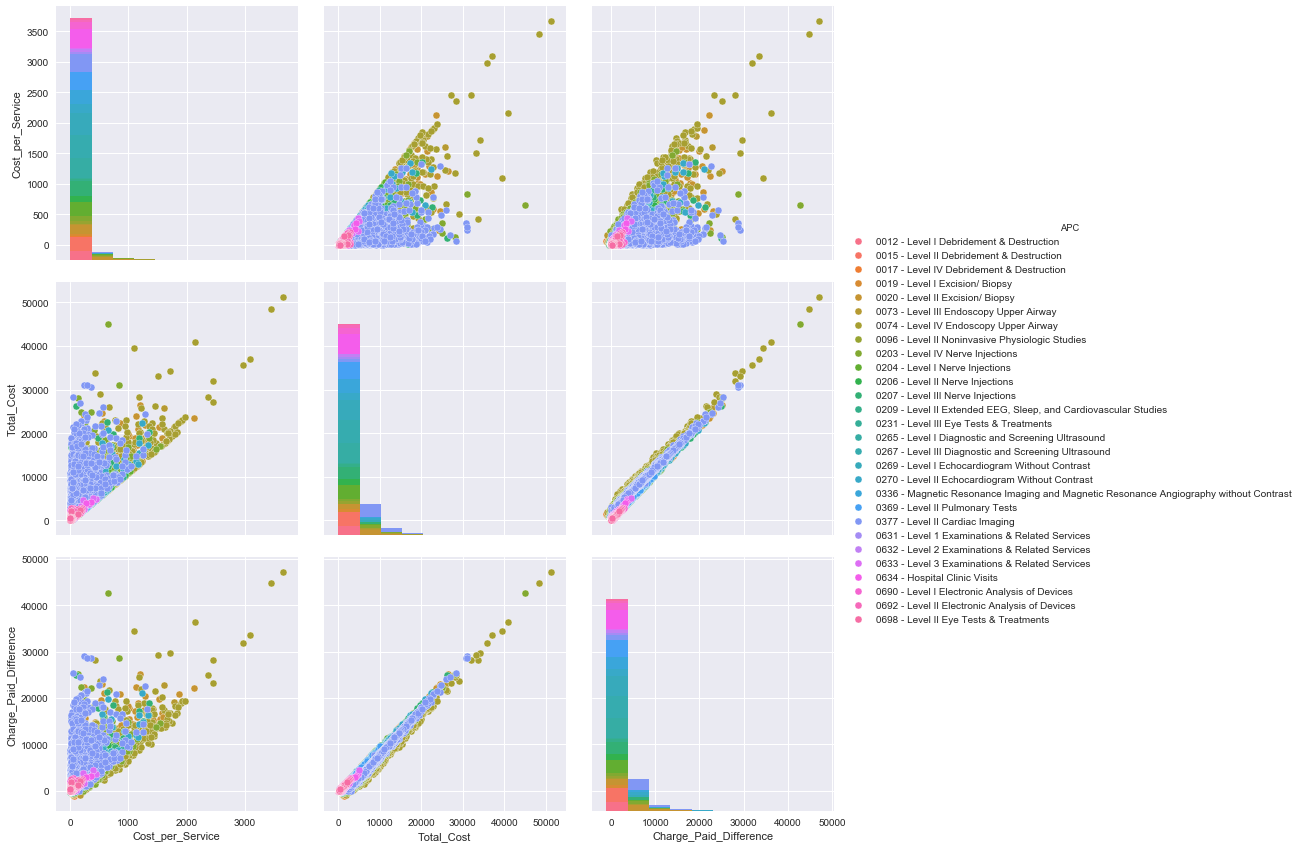

In [37]:
# Pairplot to look at a few features
ax = sns.pairplot(out_p[['Cost_per_Service', 'Total_Cost', 'APC', 'Charge_Paid_Difference']], 
             hue='APC', 
             size=4)

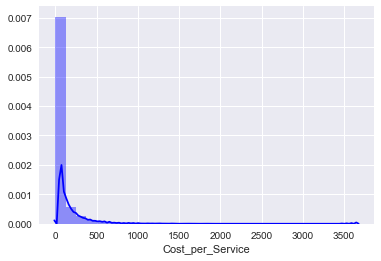

In [45]:
sns.distplot(out_p['Cost_per_Service'], bins = 30, color = 'blue')

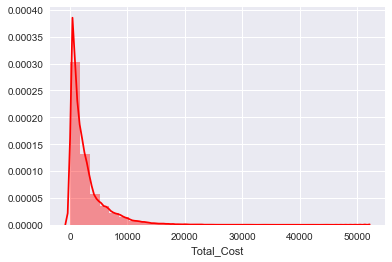

In [47]:
sns.distplot(out_p['Total_Cost'], bins = 30, color = 'red')

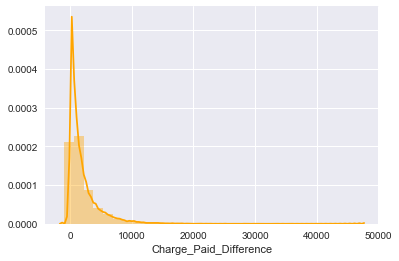

In [48]:
sns.distplot(out_p['Charge_Paid_Difference'], bins = 30, color = 'orange')

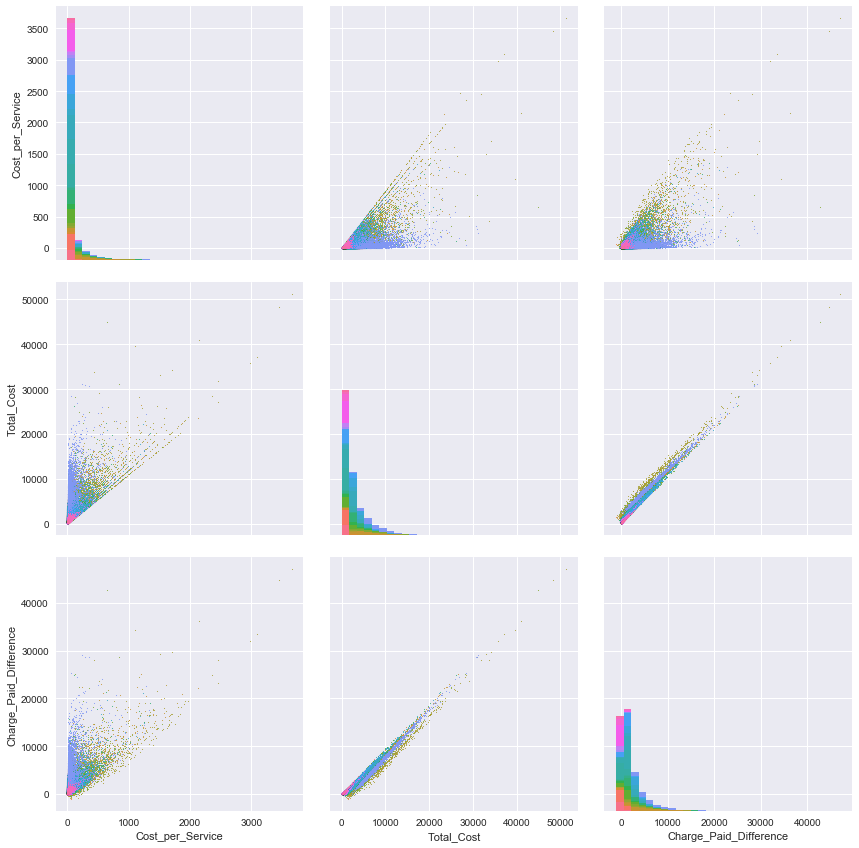

In [51]:
ax = sns.PairGrid(out_p[['Cost_per_Service', 'Total_Cost', 'APC', 'Charge_Paid_Difference']], 
             hue='APC',
             size = 4)
ax.map_diag(plt.hist, bins = 30)
ax.map_offdiag(plt.scatter, s=0.5)

#### _In-Patient_ 